In [26]:
import numpy as np

# Load dataset
data = np.load("../data/Data/mnist_test_seq.npy")  # Shape: (20, 10000, 64, 64)

# Transpose to match PyTorch format
data = np.transpose(data, (1, 0, 2, 3))  # Now: (10000, 20, 64, 64)

# Check shape
print(f"Dataset shape: {data.shape}")  # Expected: (10000, 20, 64, 64)


Dataset shape: (10000, 20, 64, 64)


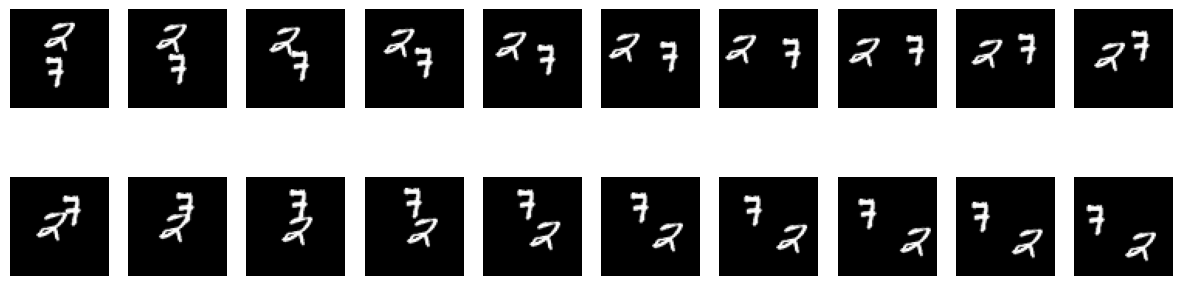

In [19]:
import matplotlib.pyplot as plt

# Select a random sequence
sequence_idx = 0  # Change this to see different sequences
sequence = data[sequence_idx]  # Shape: (20, 64, 64)

# Plot frames
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(sequence[i], cmap="gray")
    ax.axis("off")

plt.show()


In [27]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Normalize to [0,1] and convert to tensor
data = torch.tensor(data, dtype=torch.float32) / 255.0

# Add channel dimension (N, T, C, H, W)
data = data.unsqueeze(2)  # (10000, 20, 1, 64, 64)

# Split into train and test
train_data, test_data = data[:8000], data[8000:]

# Custom Dataset for Next-Frame Prediction
class MovingMNISTDataset(Dataset):
    def __init__(self, sequences):
        self.inputs = sequences[:, :10]  # First 10 frames
        self.targets = sequences[:, 10]  # 11th frame (target)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create DataLoaders
train_dataset = MovingMNISTDataset(train_data)
test_dataset = MovingMNISTDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check shapes
sample_x, sample_y = next(iter(train_loader))
print(f"Input shape: {sample_x.shape}")  # Expected: (batch_size, 10, 1, 64, 64)
print(f"Target shape: {sample_y.shape}")  # Expected: (batch_size, 1, 64, 64)


Input shape: torch.Size([16, 10, 1, 64, 64])
Target shape: torch.Size([16, 1, 64, 64])


In [28]:
import torch.nn as nn

# ConvLSTM Cell
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        padding = kernel_size // 2

        # Conv2D for input, forget, cell, and output gates
        self.conv = nn.Conv2d(in_channels=input_dim + hidden_dim,  # Combine input and hidden
                              out_channels=4 * hidden_dim, 
                              kernel_size=kernel_size, 
                              padding=padding)

    def forward(self, x, hidden_state):
        h_prev, c_prev = hidden_state
        combined = torch.cat([x, h_prev], dim=1)  # Concatenate along channel dimension
        gates = self.conv(combined)

        i, f, g, o = torch.chunk(gates, 4, dim=1)  # Split into 4 gates
        i, f, g, o = torch.sigmoid(i), torch.sigmoid(f), torch.tanh(g), torch.sigmoid(o)

        c_next = f * c_prev + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

# ConvLSTM Model
class ConvLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, kernel_size=3, num_layers=1):
        super(ConvLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm_cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size)
        self.conv_out = nn.Conv2d(hidden_dim, 1, kernel_size=1)  # Output a single-channel frame

    def forward(self, x):
        b, t, c, h, w = x.shape
        h_t = torch.zeros((b, self.hidden_dim, h, w), device=x.device)
        c_t = torch.zeros((b, self.hidden_dim, h, w), device=x.device)

        for t in range(x.shape[1]):
            h_t, c_t = self.lstm_cell(x[:, t], (h_t, c_t))  # Process each frame

        return self.conv_out(h_t)  # Output the last frame


In [39]:
import torch.optim as optim

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvLSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Remove channel dim
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/10, Loss: 0.0299
Epoch 2/10, Loss: 0.0280
Epoch 3/10, Loss: 0.0275
Epoch 4/10, Loss: 0.0272
Epoch 5/10, Loss: 0.0269
Epoch 6/10, Loss: 0.0265
Epoch 7/10, Loss: 0.0263
Epoch 8/10, Loss: 0.0261
Epoch 9/10, Loss: 0.0259
Epoch 10/10, Loss: 0.0257


Input shape: torch.Size([16, 10, 1, 64, 64])
Target shape: torch.Size([16, 1, 64, 64])
Predicted shape: (16, 1, 64, 64)


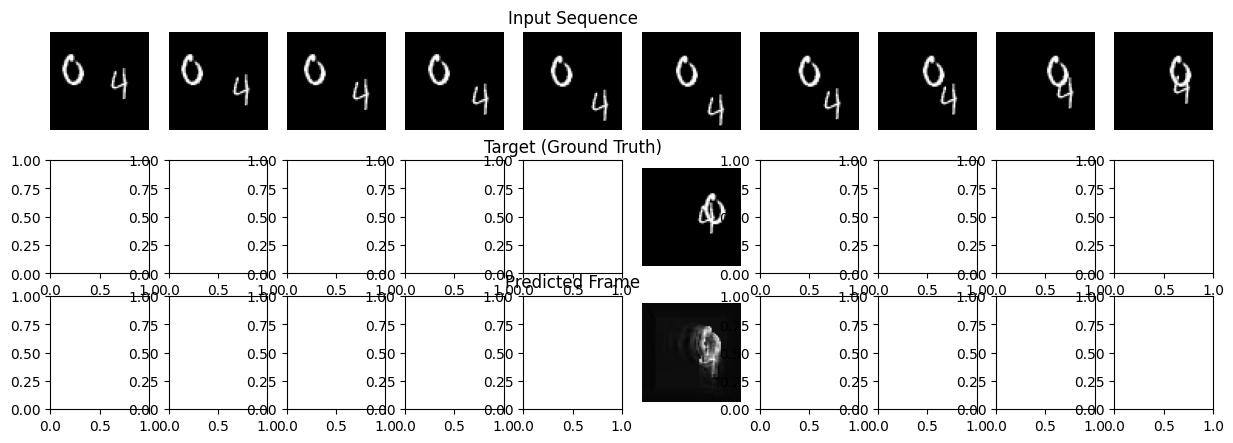

In [45]:
import torch
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    inputs, targets = next(iter(test_loader))
    inputs, targets = inputs.to(device), targets.to(device)

    predicted = model(inputs).cpu().numpy()  # Convert predictions to NumPy

# Ensure correct shape before visualization
print("Input shape:", inputs.shape)      # (batch_size, 10, 1, 64, 64)
print("Target shape:", targets.shape)    # (batch_size, 1, 64, 64)
print("Predicted shape:", predicted.shape)  # Should match targets

# Display results
fig, axes = plt.subplots(3, 10, figsize=(15, 5))

# Plot input sequence (10 frames)
for i in range(10):
    axes[0, i].imshow(inputs[0, i, 0].cpu().numpy(), cmap="gray")
    axes[0, i].axis("off")

axes[0, 4].set_title("Input Sequence")

# Plot Ground Truth (Target Frame)
axes[1, 4].set_title("Target (Ground Truth)")
axes[1, 5].imshow(targets[0, 0].cpu().numpy(), cmap="gray")  # Ensure correct shape
axes[1, 5].axis("off")

# Plot Predicted Frame
axes[2, 4].set_title("Predicted Frame")
axes[2, 5].imshow(predicted[0, 0], cmap="gray")  # No need for .squeeze(0)
axes[2, 5].axis("off")

plt.show()


In [46]:
import datetime

# Define experiment name (Example: "ConvLSTM_Exp1_2025-02-25")
experiment_name = f"ConvLSTM_Exp1_{datetime.datetime.now().strftime('%Y-%m-%d')}"

# File path to save
model_path = f"../data/Data/Model_outputs{experiment_name}.pth"

torch.save(model.state_dict(), model_path)
print(f"Model saved as {model_path}")

Model saved as ../data/Data/Model_outputsConvLSTM_Exp1_2025-02-27.pth


LOAD THE MODEL

In [ ]:
# Initialize model first
model = ConvLSTM().to(device)

# Load weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set to evaluation mode